In [1]:
import os
import numpy as np
import glob
import csv
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats

##Code for analysis of fMRI experiment

In [2]:
%matplotlib inline

In [3]:
##function for reading out data from log file
def line_to_matrix(line):
	line = line.split('=')[1]
	line = line.split(',')
	line = map(float,line)
	line = np.array(line)
	new_out = line.reshape(-1,5)
	return new_out

In [4]:
##takes the mturk results file and makes a dictionary mapping
##the worker id to the assignment id
def get_assignment_id(assignment_file):
	rowNum=0
	worker_id_2_assignment_id = {}
	with(open(assignment_file,'rU')) as f:
		reader = csv.reader(f)
		#worker id is 15 and 14
		for row in reader:
	 		if rowNum > 0:
				worker_id_2_assignment_id[row[15]] = row[14]
			rowNum += 1
	return worker_id_2_assignment_id

In [5]:
##processed RT arrays. They are coded with a negative number for pre-target responses and -1
##missed responses. This replaces -1 with NaN, changes negative to positive, and offsets positive
##RTs by the delay to the target
def clean_RT(data,delay,thresh):
    thresh = thresh + delay_dur
    if np.ndim(data) > 0:
        data[data==-1] = np.nan
        data[data>0] = data[data>0] + delay
        data[data<0] = data[data<0] *-1
    else:
        if data == -1:
            data = np.nan
        elif data>0:
            data = data + delay
        elif data < 0:
            data = data *-1
    data = data - thresh #normalize by that subject's RT in training
    return data

In [11]:
##variables and paths
data_dir = '/Users/ianballard/Dropbox/fd/'
delay_dur = 500 ##delay before target appears

In [7]:
#when just looking at one set of data at a time use this
# log_files = glob.glob(data_dir + 'data/20th_iter/*log')
# print log_files

In [8]:
def process_log_files(log_files,ip_to_id,ip_to_bonus,bad_worker,print_file_flag):
    full_data = {}
    for n,f in enumerate(log_files):
        if print_file_flag:
            print f
        bad_worker[f] = False
        subj_file = open(os.path.join(data_dir,f),'r')
        subj_file = subj_file.readlines()
        subj_file = np.array(subj_file)

        ##get sub id
        ip_to_id[f] = subj_file[0].split(' ')[1].split('=')[1]
        if subj_file.size < 16: ##check for full data
            bad_worker[f] = True
            reason = 'incomplete'
            if print_file_flag:
                print reason + ' ' + ip_to_id[f] + ' ' + f

        if bad_worker[f] == False:

            ##process file into dictionary
            subj_dict = {}
            for n,line in enumerate(subj_file):
                if n < len(subj_file) - 1:
                    subj_dict[line.split(' ')[1].split('=')[0]] = line.split(' ')[1].split('=')[1].strip('\n')
            
            #process false alarms
            subj_dict['fa'] = subj_dict['fa'].split(',')[:-1]
            
            full_data[f] = subj_dict

            ##assess quiz
            quiz_value = int(subj_dict['quiz'])
            if quiz_value != 13:
                bad_worker[f] = True
                reason = 'quiz'
                if print_file_flag:
                    print reason + ' ' + ip_to_id[f] + ' ' + f

            ##get bonus
            ip_to_bonus[f] = float(subj_dict['bonus'])

            #get number of false alarms
    #         if len(subj_dict['fa']) > 60: #more than 20 false alarms
    #             bad_worker[f] = True

            #print experiment descriptions
    #         print subj_dict['instruct'].replace('%20', ' ')
    return ip_to_id, ip_to_bonus, bad_worker, full_data

In [9]:
#preprocesses data. Takes subj_dict, string indicating which key to analyze, and dimensions to reshaping
def preprocess_data(subj_dict,key,num_entries):
    x = map(float,subj_dict[key].split(','))
    x = np.array(x)
    x = x.reshape((x.size/num_entries, num_entries))
    return x


In [10]:
##analyze reaction time data for rt thresholding task
def process_rt(log_files, full_data, bad_worker, print_file_flag):
    accuracy = np.array([])
    rt_thresh = {}
    for n,f in enumerate(log_files):
        if print_file_flag == True:
            print f
        if bad_worker[f] == False: 
            ##preprocess
            try:
                rt = preprocess_data(full_data[f], 'rt', 3)
                rt = np.array([y for y in rt if y[0]!=-2. and y[1] < 4000 and y[0] != -1.]) #remove trials without button press, bug trials, trials with missed answers
                if rt.shape[0] < 15: #missed more than 5 responses
                    bad_worker[f] = True
                else:
                    rt_thresh[f] = rt[-1,2] #last rt threshold of training
                    ##get stats
                    accuracy = np.hstack([accuracy, 1 - np.array([x for x in rt if x[0]==0.]).shape[0]/float(rt.shape[0])])
            #         if accuracy[-1] <= .3: #missed too many responses
            #             bad_worker[f] = True
                    rt = np.mean(rt, axis = 0)[1]
            except:
                print f
                bad_worker[f] = True
    print np.mean(accuracy[accuracy>.2])
    print accuracy
    return accuracy, rt_thresh

In [14]:
def analyze_rt_task(rt,rt_switch, accuracy_dict,rt_thresh, ser, rew, order,trials):
    num_f_trials = 8
    num_switch_trials = 3
    
    ##collect data
    fp_plus = np.where(order == trials[0])[-1] ##ser fp +
    fp_plus = [a for n,a in enumerate(fp_plus) if rew[fp_plus][n] == 1] 
    fp_plus_rt = clean_RT(ser[fp_plus,1],delay_dur,rt_thresh)
    accuracy_dict['fp_accuracy'] = np.hstack([accuracy_dict['fp_accuracy'],
                                             np.sum(ser[fp_plus,0] == .05)*1.0 / num_f_trials])
    
    fn_plus = np.where(order == trials[1])[-1] ##ser fn +
    fn_plus = [a for n,a in enumerate(fn_plus) if rew[fn_plus][n] == 1] 
    fn_plus_rt = clean_RT(ser[fn_plus,1],delay_dur,rt_thresh)
    accuracy_dict['fn_accuracy'] = np.hstack([accuracy_dict['fn_accuracy'],
                                             np.sum(ser[fn_plus,0] == .05)*1.0 / num_f_trials])
    
    fp_switch = np.where(order == trials[2])[-1] ##ser fp +
    fp_switch = [a for n,a in enumerate(fp_switch) if rew[fp_switch][n] == 1] 
    fp_switch_rt = clean_RT(ser[fp_switch,1],delay_dur,rt_thresh)
    accuracy_dict['fp_switch_accuracy'] = np.hstack([accuracy_dict['fp_switch_accuracy'],
                                             np.sum(ser[fp_switch,0] == .05)*1.0 / num_switch_trials])    
    
    fn_switch = np.where(order == trials[3])[-1] ##ser fn +
    fn_switch = [a for n,a in enumerate(fn_switch) if rew[fn_switch][n] == 1] 
    fn_switch_rt = clean_RT(ser[fn_switch,1],delay_dur,rt_thresh)
    accuracy_dict['fn_switch_accuracy'] = np.hstack([accuracy_dict['fn_switch_accuracy'],
                                             np.sum(ser[fp_switch,0] == .05)*1.0 / num_switch_trials]) 

    rt.append(pd.DataFrame(dict(condition=["fn"] * num_f_trials,
                                    subj = [f] * num_f_trials,
                                    presentation = np.arange(0,num_f_trials),
                                    RT = fn_plus_rt), dtype=np.float))
    rt.append(pd.DataFrame(dict(condition=["fp"] * num_f_trials,
                            subj = [f] * num_f_trials,
                            presentation = np.arange(0,num_f_trials),
                            RT = fp_plus_rt), dtype=np.float))    
    rt_switch.append(pd.DataFrame(dict(condition=["fn"] * num_switch_trials,
                                    subj = [f] * num_switch_trials,
                                    presentation = np.arange(0,num_switch_trials),
                                    RT = fn_switch_rt), dtype=np.float))
    rt_switch.append(pd.DataFrame(dict(condition=["fp"] * num_switch_trials,
                            subj = [f] * num_switch_trials,
                            presentation = np.arange(0,num_switch_trials),
                            RT = fp_switch_rt), dtype=np.float))    
    return rt,rt_switch,accuracy_dict


In [33]:
##MAIN ANALYSIS CODE
##process data for both sim and ser experiments
log_files = glob.glob(data_dir + 'data/24th_iter/*log')

ip_to_bonus = {}
ip_to_id = {}
bad_worker = {}
ip_to_bonus = {}

##process log files
ip_to_id, ip_to_bonus, bad_worker, full_data = process_log_files(log_files,ip_to_id,ip_to_bonus,bad_worker,False)

##analyze RT
accuracy, rt_thresh = process_rt(log_files, full_data, bad_worker, False)


0.547619047619
[ 0.6         0.6         0.6         0.46666667  0.6         0.53333333
  0.53333333  0.46666667  0.6         0.6         0.4         0.6         0.6
  0.46666667]


In [34]:
##analyze rt data for the serial and simultaneous task and build dataframe
num_trials = 11 #num trials per condition
rt_sim = []
rt_switch_sim = []
rt_ser = []
rt_switch_ser = []
accuracy_dict_ser = {'fp_accuracy': [], 'fn_accuracy': [],'fp_switch_accuracy': [], 'fn_switch_accuracy':[]}
accuracy_dict_sim = {'fp_accuracy': [], 'fn_accuracy': [],'fp_switch_accuracy': [], 'fn_switch_accuracy':[]}

for n,f in enumerate(log_files):
    if bad_worker[f] == False: 
        ##preprocess
        ser = preprocess_data(full_data[f], 'ser', 3)
        ser = np.array([y for y in ser if y[1] < 5000]) ##remove bug trials
        
        cond = np.array( map(float, full_data[f]['cond'].split(',') ))
        rew =  np.array( map(float, full_data[f]['rew'].split(',') ))
        order = np.array( map(float, full_data[f]['trial_order'].split(',')))        
        
        if len(ser) == 88: #simultaneous
            rt_sim,rt_switch_sim,accuracy_dict_sim = analyze_rt_task(rt_sim, rt_switch_sim, accuracy_dict_sim, rt_thresh[f],
                                                                 ser, rew, order,[1,4,2,3])
        elif len(ser) == 110: #serial
            rt_ser,rt_switch_ser,accuracy_dict_ser = analyze_rt_task(rt_ser, rt_switch_ser, accuracy_dict_ser, rt_thresh[f], 
                                                                 ser, rew, order,[2,6,3,5])
print len(rt_ser)
print len(rt_sim)

rt_ser = pd.concat(rt_ser)
rt_switch_ser = pd.concat(rt_switch_ser)
#rt_sim = pd.concat(rt_sim)
#rt_switch_sim = pd.concat(rt_switch_sim)

28
0


In [35]:
print np.mean(accuracy_dict_ser['fp_accuracy'])
print np.mean(accuracy_dict_ser['fn_accuracy'])
print np.mean(accuracy_dict_sim['fp_accuracy'])
print np.mean(accuracy_dict_sim['fn_accuracy'])

print len(accuracy_dict_sim['fn_accuracy'])
print len(accuracy_dict_ser['fn_accuracy'])

0.767857142857
0.821428571429
nan
nan
0
14


/Users/ianballard/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


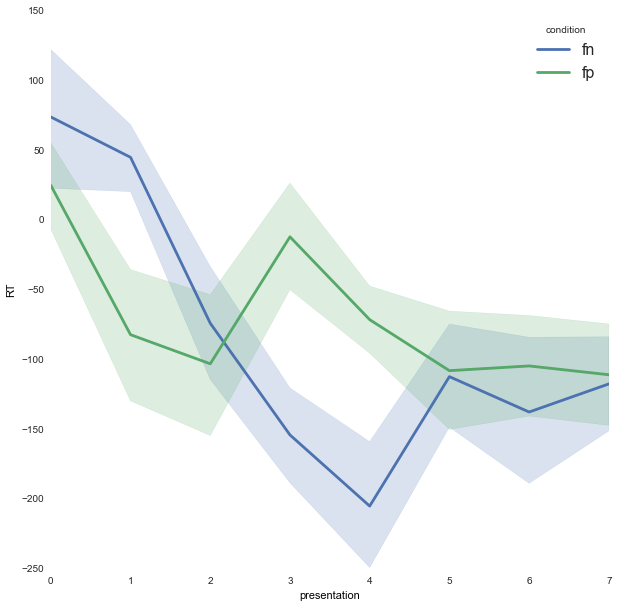

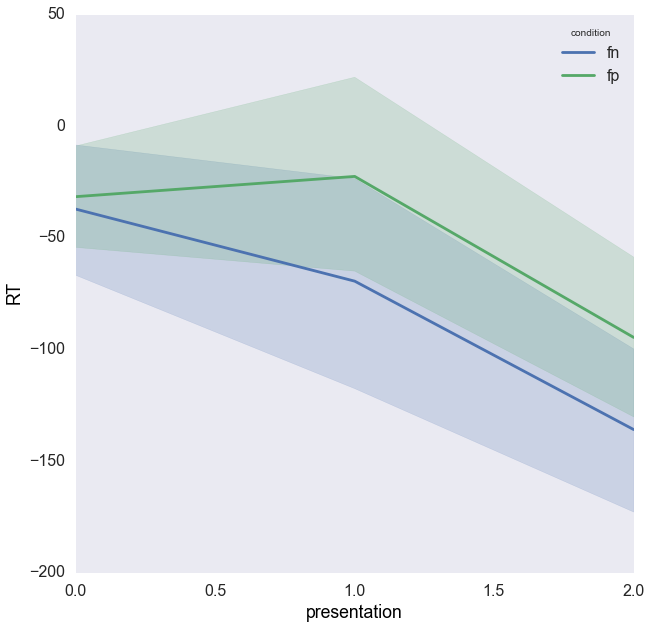

In [36]:
f, ax = plt.subplots(figsize=(10, 10))
sns.set(context='poster')
sns.despine()
sns.tsplot(rt_ser, time="presentation", unit="subj", condition="condition", value="RT",estimator=np.nanmean);
ax.xaxis.grid(False)
ax.yaxis.grid(False)
# plt.savefig(data_dir + 'fd.tiff', dpi=600,orientation='landscape')

f, ax = plt.subplots(figsize=(10, 10))
sns.set(context='poster')
sns.despine()
sns.tsplot(rt_switch_ser, time="presentation", unit="subj", condition="condition", value="RT",estimator=np.nanmean);
ax.xaxis.grid(False)
ax.yaxis.grid(False)
# plt.savefig(data_dir + 'fd.tiff', dpi=600,orientation='landscape')

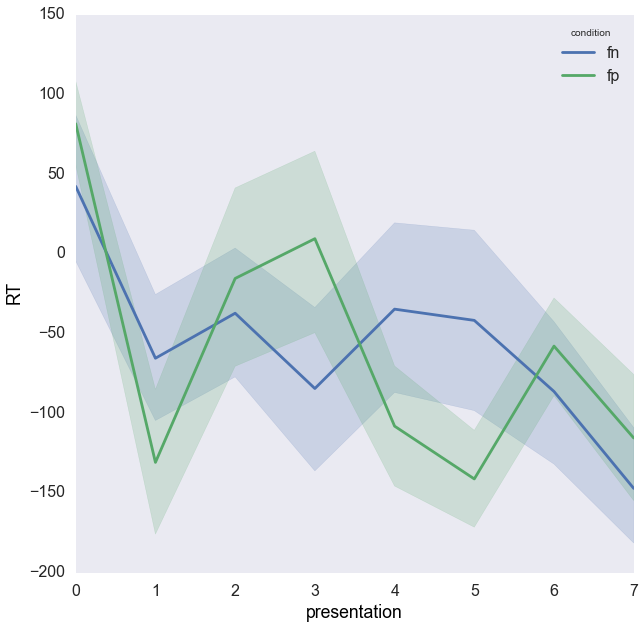

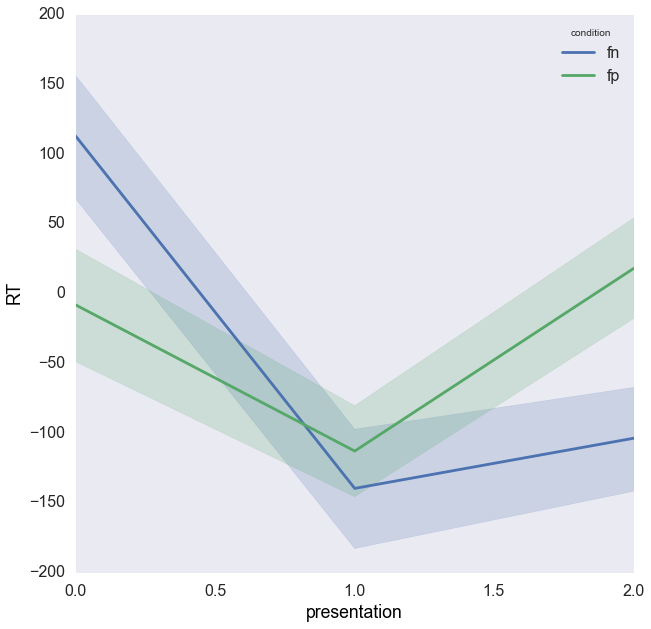

In [198]:
f, ax = plt.subplots(figsize=(10, 10))
sns.set(context='poster')
sns.despine()
sns.tsplot(rt_sim, time="presentation", unit="subj", condition="condition", value="RT",estimator=np.nanmean);
ax.xaxis.grid(False)
ax.yaxis.grid(False)
# plt.savefig(data_dir + 'fd.tiff', dpi=600,orientation='landscape')

f, ax = plt.subplots(figsize=(10, 10))
sns.set(context='poster')
sns.despine()
sns.tsplot(rt_switch_sim, time="presentation", unit="subj", condition="condition", value="RT",estimator=np.nanmean);
ax.xaxis.grid(False)
ax.yaxis.grid(False)
# plt.savefig(data_dir + 'fd.tiff', dpi=600,orientation='landscape')

In [37]:
##payment  
assignment_file = os.path.join(data_dir,'results/Batch_1837042_batch_results.csv')
payment_file = os.path.join(data_dir,'results/payment23.txt')
worker_id_2_assignment_id = get_assignment_id(assignment_file)

iter_list = set(ip_to_id.keys())
completed = []

for n,f in enumerate(iter_list):
    if bad_worker[f] == False:
        sub_id = ip_to_id[f].strip('\n')
        try:
            assignment_id = worker_id_2_assignment_id[ip_to_id[f].strip('\n')]

        except:
             print ip_to_id[f] + ' is not in results file' + f
        
        else:
            if sub_id not in completed: #output results
                completed = completed + [sub_id]
                out_str = [assignment_id ,sub_id , str(ip_to_bonus[f] + 1.5)]
                if ip_to_bonus[f] > 0:
                    pay = open(payment_file,'a')
                    pay.write('\t'.join(out_str))
                    pay.write('\n')

A357X6NIBOTHH0
 is not in results file/Users/ianballard/Dropbox/fd/data/24th_iter/71.176.17.136.log
13
 is not in results file/Users/ianballard/Dropbox/fd/data/24th_iter/68.96.171.148.log
